[//]:# (This lab is based on https://sandipanweb.wordpress.com/2020/12/08/travelling-salesman-problem-tsp-with-python/)
# Travelling salesman problem
TSP is a well known problem that we can formulate as this:

A salesman wants to visit some cities each exactly once then return to the
starting city, given the distance between the cities calculate the rout with
the least total distance.

In [1]:
from itertools import permutations, combinations
from time import time
import numpy as np
from tqdm import tqdm

In [2]:
# https://developers.google.com/optimization/routing/tsp
# Distances matrix, dist[i][j] -> distance from city_i to city_j
dist = np.array([
    [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
    [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
    [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
    [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
    [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
    [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
    [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
    [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
    [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
    [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
    [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
    [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
    [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
])

Best route and best score for this problem are: 

**best_route** = [0, 7, 2, 3, 4, 12, 6, 8, 1, 11, 10, 5, 9]

**best_score** = 7293.0

# Genetics Algorithms
> Machines would be more useful if they could learn to perform tasks for which
> they were not given precise methods.
>
> --Richard Friedberg [Friedberg, 1958]

GAs can be applied to many problems that is difficult to calculate an exact
solution.

The main principles of GAs are:
1. A biological system includes a population of individuals, many of which have the ability to reproduce.
2. The individuals have a finite life span.
3. There is variation in the population.
4. The ability to survive is positively correlated with the ability to reproduce.

![GA steps](https://www.tutorialspoint.com/genetic_algorithms/images/basic_structure.jpg)


For GA we need the following:
- Express a possible solution as a gene
- Fitness function
- Mutation function
- Crossover
- Selection criteria
    - Rank selection: The individuals with the highest fitness survive
    - Fitness proportionate: $P_{survival}(i) = \frac{Fitness(i)}{\sum_j^n Fitness(j)}$

In [26]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
# Fill the following functions

def do_crossover(s1, s2):
    # TODO: write a reasonable crossover
    # TODO: should return two children
    
    m = random.randint(1, len(s1) - 1)
    child = [None] * len(s1)
    # in child fix genes of s1 that are contained in s2 (starting from gene m)
    for i in range(m):
        if s1[i] in s2[m:]:
            child[i] = s1[i]
            s1[i] = None
            s2[s2.index(child[i])] = None

    # add to child genes of s2 starting from m
    for i in range(m, len(s2)):
        if s2[i] is not None:
            child[i] = s2[i]
            s1[s1.index(child[i])] = None
            
    # fill blank spaces of the child with numbers which haven't been added yet
    # in the same order as it is in s1
    child_i, i1 = 0, 0
    while i1 < len(child) and child_i < len(child):
        while i1 < len(child) and s1[i1] is None:
            i1 += 1
        while child_i < len(child) and child[child_i] is not None:
            child_i += 1
            
        if i1 < len(child) and child_i < len(child):
            child[child_i] = s1[i1]
            i1 += 1
            child_i += 1
            
    return child

# mutation_p - important!
# too high - almost a random search
# too low - no variability
def do_mutation(individual, mutation_p): 
    if random.random() < mutation_p:
        i1, i2 = np.random.choice(np.arange(len(individual)), size=(2,), replace=False)
        individual[i1], individual[i2] = individual[i2], individual[i1]
    return individual

def compute_fitness(G, s):
    total_distance = G[s[-1], s[0]]
    for i in range(len(s) - 1):
        total_distance += G[s[i], s[i + 1]]

    return total_distance

def get_elite(G, gen, k):
    gen = sorted(gen, key=lambda x: compute_fitness(G, x))
    return gen[:k]

def generate_population(n, k):
    pop = []
    example = np.arange(k)
    for i in range(n):
        np.random.shuffle(example)
        pop.append(example.copy())
    return np.array(pop)

def make_children(population, fitness):
    # It is a minimization problem in our task
    # But roulette selection of parents assumes a maximization problem
    # Therefore I invert the fitnesses and add some value to them so that they become positive.
    # In such a way an individual with highest fitness will get the lowest probability
    max_fit = fitness.max() + 1000
    probs = (max_fit - fitness) / np.sum(max_fit - fitness)
    children = []
    indices = np.arange(len(population))
    parent_indices = np.random.choice(indices, size=2*len(indices), p=probs, replace=True)
    for i in range(0, len(parent_indices) - 1, 2):
        p1, p2 = population[parent_indices[i]], population[parent_indices[i + 1]]
        # produce offsprings
        child = do_crossover(p1.tolist(), p2.tolist())
        children.append(np.array(child))

    return children

def TSP_GA(G, k=30, ntrial = 1000, keep_parents=None, mutation_p=0.02, show_graphs=False):
    population = generate_population(k, len(G))
    best_fitnesses = []
    mean_fitnesses = []
    trials = range(ntrial)
    if show_graphs:
        trials = tqdm(trials)
        
    for trial in trials:
        fitnesses = list(map(lambda x: compute_fitness(G, x), population))
        fitnesses = np.array(fitnesses)
        # for evolution visualization
        best_fitnesses.append(np.min(fitnesses))
        mean_fitnesses.append(np.mean(fitnesses))
        
        # create children
        children = make_children(population, fitnesses)
        children = list(map(lambda x: do_mutation(x, mutation_p), children))
        if keep_parents is not None:
            # get 'keep_parents' most fitted parent individuals
            elite = get_elite(G, population, keep_parents)
            # sort children 
            sorted_children = get_elite(G, children, len(children))
            population = sorted_children[:-1] + elite
        else:
            population = children
        
    # best score on the last generation
    fitnesses = list(map(lambda x: compute_fitness(G, x), population))
    best_individual_index = np.argmin(fitnesses)
    
    # visualize evolution process
    if show_graphs:
        plt.plot(best_fitnesses, color='red')
        plt.plot(mean_fitnesses, color='blue')
        plt.show()
        
    return fitnesses[best_individual_index], population[best_individual_index]

  0%|          | 0/1000 [00:00<?, ?it/s]

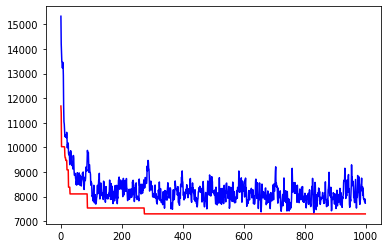

(7293, array([12,  6,  8,  1, 11, 10,  5,  9,  0,  7,  2,  3,  4]))

In [31]:
TSP_GA(dist, keep_parents=1, mutation_p=0.2, show_graphs=True)

What is the effect of letting the parents survive?

To evaluate the performance of GA we take an average since it's a
nondeterministic approximation algorithm.

In [32]:
# Results for GA without saving most fitted parents
n_tests = 20
scores = []
times = []
best_score, best_route = None, None
for i in tqdm(range(n_tests)):
    start_time = time()
    if best_score is None and best_route is None:
        best_score, best_route = TSP_GA(dist, k = 100, ntrial=500, mutation_p=0.15)
        scores.append(best_score)
    else:
        score, route = TSP_GA(dist, k = 100, ntrial=500, mutation_p=0.15)
        if score < best_score:
            best_route = route
            best_score = score
        scores.append(score)

    total_time = time() - start_time
    times.append(total_time)


print(f"best_route: {best_route}")
print(f"mean score: {np.mean(scores)}")
print(f"mean time: {np.mean(total_time): 0.3f}s")

# Results for GA with saving most fitted parents
best_score, best_route = None, None
for i in tqdm(range(n_tests)):
    start_time = time()
    if best_score is None and best_route is None:
        best_score, best_route = TSP_GA(dist, k = 100, ntrial=500, mutation_p=0.15, keep_parents=1)
        scores.append(best_score)
    else:
        score, route = TSP_GA(dist, k = 100, ntrial=500, mutation_p=0.15, keep_parents=1)
        if score < best_score:
            best_route = route
            best_score = score
        scores.append(score)

    total_time = time() - start_time
    times.append(total_time)

print(f"best_route: {best_route}")
print(f"mean score: {np.mean(scores)}")
print(f"mean time: {np.mean(total_time): 0.3f}s")



  0%|          | 0/20 [00:00<?, ?it/s]

best_route: [ 1 11 10  5  9  0  7  2  3  4 12  6  8]
mean score: 7460.3
mean time:  1.022s


  0%|          | 0/20 [00:00<?, ?it/s]

best_route: [ 9  5 10 11  1  8  6 12  4  3  2  7  0]
mean score: 7418.25
mean time:  1.538s
